# Structural Estimation of Market Parameters

### Hybrid Direct Estimator

In [1]:
using Pkg
Pkg.activate(".")
#for pkg in ["BlackBoxOptim", "Cubature", "Distributions", "Integrals", "Roots", "PythonPlot", "PrettyTables", "JLD", "StatProfilerHTML"] # 
#    Pkg.add(pkg)
#end

Pkg.instantiate()

using BlackBoxOptim, Cubature, Distributions, Integrals, Random, Roots, PythonPlot, PrettyTables, JLD

  Activating project at `C:\Users\jbrig\Documents\research\mapinator_2024\notes\estimation_of_tau`
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonCall\Nr75f\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonPlot\469aA\CondaPkg.toml
    CondaPkg Dependencies already up to date


## 1. Load placements

In [2]:
placement_matrices = load("placement_matrices.jld")

Dict{String, Any} with 4 entries:
  "successful_tier_1_range" => 2018:2023
  "placement_matrix"        => [761 115 … 8 0; 879 569 … 48 4; … ; 165 244 … 20…
  "successful_tier_1"       => 2098
  "unmatched"               => [300, 544, 667, 364, 273]

In [3]:
placement_rates_raw = placement_matrices["placement_matrix"]

10×5 Matrix{Int64}:
 761  115   41    8    0
 879  569  148   48    4
 839  993  443   60   14
 176  306  217  140   11
   3   14   16   15   46
 582  596  301   79   19
 700  438  244   68   24
 218  187  114   39    9
 165  244  315  201  104
 676  967  815  309  123

In [4]:
unmatched_raw = placement_matrices["unmatched"]

5-element Vector{Int64}:
 300
 544
 667
 364
 273

In [5]:
k = size(placement_rates_raw)[2]
K = size(placement_rates_raw)[1]

10

## 2. Rescale placements (successes and failures) using registrations

In [6]:
# conduct adjustment using the relative m_t values
adjustment_matrix = load("adjustment_matrix.jld")
m_t_values = adjustment_matrix["data"][:, 1]

5-element Vector{Any}:
 2664
 3635
 4481
 2284
 1347

In [7]:
m_t_placements = zeros(Int, k)
for t in 1:k
    m_t_placements[t] = sum(placement_rates_raw[:, t]) + unmatched_raw[t]
end
m_t_placements

5-element Vector{Int64}:
 5299
 4973
 3321
 1331
  627

In [8]:
placement_rates_rescaled = zeros(Int, K, k)
unmatched_rescaled = zeros(Int, k)

for i in 1:K
    for t in 1:k
        placement_rates_rescaled[i, t] = round(m_t_values[t] * (placement_rates_raw[i, t] / m_t_placements[t]))
    end
end

for t in 1:k
    unmatched_rescaled[t] = round(m_t_values[t] * (unmatched_raw[t] / m_t_placements[t]))
end

placement_rates_rescaled

10×5 Matrix{Int64}:
 383   84    55   14    0
 442  416   200   82    9
 422  726   598  103   30
  88  224   293  240   24
   2   10    22   26   99
 293  436   406  136   41
 352  320   329  117   52
 110  137   154   67   19
  83  178   425  345  223
 340  707  1100  530  264

In [9]:
unmatched_rescaled

5-element Vector{Int64}:
 151
 398
 900
 625
 586

## 3. Collapse sinks and delete graduating tier 5 (tier 5 becomes part of the sinks)

In [10]:
println("original dimensions: ", K, " by ", k)

original dimensions: 10 by 5


In [11]:
k -= 1
K = k + 3

7

In [12]:
println("new dimensions: ", K, " by ", k)

new dimensions: 7 by 4


In [13]:
placement_rates = zeros(Int, K, k)
for i in 1:4 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i, t] = placement_rates_rescaled[i, t]
    end
end

for i in 5:6 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i, t] = placement_rates_rescaled[i+1, t]
    end
end

for t in 1:k
    # NOTE: hardcoded
    for original_sink_tier in [5, 8, 9, 10]
        placement_rates[K, t] += placement_rates_rescaled[original_sink_tier, t] 
    end
end

unmatched = zeros(Int, k)
for t in 1:k
    unmatched[t] = unmatched_rescaled[t]
end

placement_rates

7×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968

In [14]:
unmatched

4-element Vector{Int64}:
 151
 398
 900
 625

## 3a. Latex version of the new table

In [15]:
presentation_table = zeros(Int, K+1, k)
for i in 1:K, t in 1:k
    presentation_table[i, t] = placement_rates[i, t]
end

for t in 1:k
    presentation_table[K+1, t] = unmatched[t]
end

In [16]:
include("type_allocation_base_by_applicant.jl")

Main.SBM

In [17]:
presentation_table

8×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968
 151   398   900  625

In [18]:
sink_names_to_present = [
    "Public Sector",
    "Private Sector",
    "Other",
    "Unmatched"
]
SBM.nice_table(presentation_table, k, (K - k) + 1, sink_names_to_present)

┌────────────────┬────────┬────────┬────────┬────────┬────────────┐
│                │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Row Totals │
├────────────────┼────────┼────────┼────────┼────────┼────────────┤
│         Tier 1 │    383 │     84 │     55 │     14 │        536 │
│         Tier 2 │    442 │    416 │    200 │     82 │       1140 │
│         Tier 3 │    422 │    726 │    598 │    103 │       1849 │
│         Tier 4 │     88 │    224 │    293 │    240 │        845 │
│  Public Sector │    293 │    436 │    406 │    136 │       1271 │
│ Private Sector │    352 │    320 │    329 │    117 │       1118 │
│          Other │    535 │   1032 │   1701 │    968 │       4236 │
│      Unmatched │    151 │    398 │    900 │    625 │       2074 │
│  Column Totals │   2666 │   3636 │   4482 │   2285 │      13069 │
└────────────────┴────────┴────────┴────────┴────────┴────────────┘
\begin{tabular}{rrrrrr}
  \hline
   & \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3} & \textbf{Tier 4} & \textb

## 4. Compute $m$ and $\gamma_t$

In [19]:
res = (; placements = placement_rates) 

M = sum(res.placements)

successful_graduates = [sum(res.placements[:, t]) for t in 1:k]
println("successful graduates: ", M)
println(successful_graduates)
println()

estimated_m_val = sum(m_t_values)

successful graduates: 10995
[2515, 3238, 3582, 1660]



14411

In [20]:
estimated_γ = m_t_values / estimated_m_val

5-element Vector{Float64}:
 0.1848587884255083
 0.25223787384636737
 0.31094302963014364
 0.15849004232877664
 0.09347026576920409

## 5. Estimate $\frac{v_{t+1}}{v_t}$ and $\tau$ simultaneously

In [21]:
# define p_vec as e.g.
# [v2/v1 v3/v2 v4/v3 α1 α2 α3 α4 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]

function F(x, ρ, phi, K)
    sum_base = 0.0
    for i in 1:K
        sum_base += ρ[i] * x^phi[i]
    end
    return sum_base
end

function f_integrand(integrals, x, p) 
    base_exp = exp(F(x, p.ρ, p.phi, p.K) / sum(p.α[1:p.s]))
    for i in 1:p.K
        integrals[i] = base_exp * p.phi[i] * x^(p.phi[i] - 1)
    end
end

function get_integrals(x_vec, ρ, phi, α, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    all_integrals = zeros(K, k)
    for s in 1:k
        # https://docs.sciml.ai/Integrals/stable/basics/SampledIntegralProblem/ might be faster
        # if f_integrand(x) can be vectorized/sped up
        prob = IntegralProblem(IntegralFunction(f_integrand, zeros(K)), (x_vec[s+1], x_vec[s]), (; s, ρ, phi, α, K))
        sol = solve(prob, CubatureJLh(); reltol = 1e-6, abstol = 1e-6)
        integrals_result = sol.u
        # NOTE: result may be inf if alpha_1 is too small
        # NOTE: some parameter values for μ and σ may cause the cdf F_i to be NaN
        for i in 1:K 
            all_integrals[i, s] = integrals_result[i]
        end
    end
    return all_integrals
end      

function q(i, t, all_integrals, Fx_vec, α, v_rel, k)
    return α[t] * sum([(1/sum(α[1:s])) * prod([v_rel[j] for j in t:(s-1)]) * exp(-Fx_vec[s] / sum(α[1:s])) * all_integrals[i, s] for s in t:k])
end


function f_integrand_simple(x, p) 
    base_exp = exp(F(x, p.ρ_true, p.phi_true, p.K) / sum(p.α[1:p.s]))
    return base_exp * p.phi_i * x^(p.phi_i - 1)
end

function get_integral_row(x_vec, phi_i, phi_true, ρ_true, α, k, K)
    all_integrals = zeros(k)
    for s in 1:k
        prob = IntegralProblem(f_integrand_simple, (x_vec[s+1], x_vec[s]), (; s, phi_i, phi_true, ρ_true, α, K))
        sol = solve(prob, CubatureJLh(); reltol = 1e-6, abstol = 1e-6)
        all_integrals[s] = sol.u
    end
    return all_integrals
end

function q_i(t, all_integrals, Fx_vec, α, v_rel, k)
    return α[t] * sum([(1/sum(α[1:s])) * prod([v_rel[j] for j in t:(s-1)]) * exp(-Fx_vec[s] / sum(α[1:s])) * all_integrals[s] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

function ρ_q(t, α, v_rel, k)
    Fx_km1 = Fx(k-1, α, v_rel)
    if Fx_km1 <= 0
        return -1
    end
    last_term = prod([v_rel[j] for j in t:(k-1)]) * (1 - exp((0 - Fx_km1) / sum(α[1:k])))
    return α[t] * (sum([prod([v_rel[j] for j in t:(s-1)]) * (1 - v_rel[s]) for s in t:(k-1)]) + last_term)
end

ρ_q (generic function with 1 method)

In [22]:
function estimate_parameters_stage_1(p_vec, placements, γ, m_val, k)
    v_rel = p_vec[1:k-1]
    τ = p_vec[k]
    α = τ * γ

    n_val = (m_val / τ) + 1

    objective = 0.0

    ρ_q_t = zeros(k)
    for t in 1:k
        prob = ρ_q(t, α, v_rel, k)
        if prob < 0
            return Inf
        end
        ρ_q_t[t] = prob
    end

    for t in 1:k
        prob = ρ_q_t[t]
        expectation = n_val * prob
        objective += ((sum(placements[:, t]) - expectation) ^ 2) / expectation
    end
    
    return objective
end

estimate_parameters_stage_1 (generic function with 1 method)

In [23]:
Random.seed!(0)

# upper/lower bound on v_rel
upper_1 = [1.0 for _ in 1:k-1]
lower_1 = [0.0 for _ in 1:k-1]

# upper/lower bound on τ
append!(upper_1, [10.0 for _ in 1:1])
append!(lower_1, [0.25 for _ in 1:1])

search_range_1 = [(lower_1[i], upper_1[i]) for i in eachindex(upper_1)]
sol_res_1 = bboptimize(p -> estimate_parameters_stage_1(p, res.placements, estimated_γ, estimated_m_val, k), SearchRange = search_range_1, MaxFuncEvals = 1000000, TraceInterval = 5) 
# MaxTime = 60.0, MaxFuncEvals = 500000,
sol_1 = best_candidate(sol_res_1)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 1099017 steps and 1.79 seconds
Termination reason: Max number of function evaluations (1000000) reached
Steps per second = 615695.77
Function evals per second = 560224.62
Improvements/step = Inf
Total function evaluations = 1000001


Best candidate found: [0.512286, 0.544467, 0.734376, 0.556643]

Fitness: 0.000000000



4-element Vector{Float64}:
 0.5122856729316837
 0.5444666789677739
 0.7343759862308326
 0.5566428717441424

In [24]:
estimated_v_rel = sol_1[1:k-1]
estimated_τ = sol_1[k]

0.5566428717441424

In [25]:
println("estimated value ratios:")
display(estimated_v_rel)
println()
estimated_v_base = 1
for i in 1:k
    println("v", i, ": ", estimated_v_base)
    if i != k
        estimated_v_base = estimated_v_rel[i] * estimated_v_base
    end
end
println()

println("estimated market balance ratio (m / (n-1)): ", estimated_τ)

estimated_n_val = (estimated_m_val / estimated_τ) + 1
println("estimated total departments: ", estimated_n_val)
estimated_α = estimated_τ * estimated_γ
println("estimated α_t: ", estimated_α)

estimated value ratios:


3-element Vector{Float64}:
 0.5122856729316837
 0.5444666789677739
 0.7343759862308326


v1: 1
v2: 0.5122856729316837
v3: 0.27892247902388506
v4: 0.2048339706151143

estimated market balance ratio (m / (n-1)): 0.5566428717441424
estimated total departments: 25890.130592556892
estimated α_t: [0.10290032685631777, 0.14040641446047863, 0.17308422096214712, 0.08822235230474092, 0.05202955716045797]


## 6. Estimate $\rho_i$, $\mu_i$ and $\sigma_i$

In [26]:
function estimate_likelihood_2(p_vec, v_rel, α, placements, k, K, counter)   
    phi = p_vec[1:K]
    ρ_vec = p_vec[K+1:2K]
    ρ = ρ_vec / sum(ρ_vec)

    ## compute the cutoffs x and the CDF values F(x)
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.00000001
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, phi, K) - Fx_vec[t+1], (0.0, 1.0)) 
    end 

    ρ_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, phi, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        ρ_q_it[i, t] = ρ[i] * prob
    end

    normalizer = sum(ρ_q_it)
    likelihood = 0.0
    for i in 1:K, t in 1:k
        likelihood += placements[i, t] * log(ρ_q_it[i, t] / normalizer)
    end

    counter[1] += 1
    if isnan(-likelihood) || isinf(-likelihood)
        println(all_integrals)
    end
    return -likelihood
end

estimate_likelihood_2 (generic function with 1 method)

In [27]:
Random.seed!(0)

# upper/lower bound on phi parameter of exponentiated uniform
upper_2 = [10.0 for _ in 1:K]
lower_2 = [0.01 for _ in 1:K]

# upper/lower bound on values proportional to ρ_i
append!(upper_2, [1.0 for _ in 1:K])
append!(lower_2, [0.0 for _ in 1:K])

counter = [0]

search_range_2 = [(lower_2[i], upper_2[i]) for i in eachindex(upper_2)]
sol_res_2 = bboptimize(p -> estimate_likelihood_2(p, estimated_v_rel, estimated_α, res.placements, k, K, counter), SearchRange = search_range_2, MaxFuncEvals = 100000, TraceInterval = 5) 
# MaxTime = 60.0, MaxFuncEvals = 500000,
sol_2 = best_candidate(sol_res_2)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 16792 evals, 16688 steps, improv/step: 0.194 (last = 0.1936), fitness=33063.459451399
10.00 secs, 32473 evals, 32373 steps, improv/step: 0.174 (last = 0.1522), fitness=33063.424795172
15.00 secs, 48121 evals, 48023 steps, improv/step: 0.163 (last = 0.1404), fitness=33063.424794787
20.00 secs, 63689 evals, 63595 steps, improv/step: 0.149 (last = 0.1054), fitness=33063.424794787
25.01 secs, 79247 evals, 79165 steps, improv/step: 0.129 (last = 0.0479), fitness=33063.424794787
30.01 secs, 94826 evals, 101283 steps, improv/step: 0.122 (last = 0.0996), fitness=33063.424794787

Optimization stopped after 113282 steps and 31.69 seconds
Termination reason: Max number of function evaluations (100000) reached
Steps per second = 3574.13
Function evals per second = 3155.10
Improvements/s

14-element Vector{Float64}:
 9.999999999948804
 4.398285851957321
 2.7202008600268877
 0.23863503235387787
 2.0772261810227945
 2.5618692551777658
 0.39469872767744907
 0.06377866072324617
 0.15063568241315142
 0.2630011898483695
 0.2320022405581083
 0.18998475132671547
 0.1606968606448836
 0.9860983336226462

In [28]:
estimated_phi = sol_2[1:K]

7-element Vector{Float64}:
 9.999999999948804
 4.398285851957321
 2.7202008600268877
 0.23863503235387787
 2.0772261810227945
 2.5618692551777658
 0.39469872767744907

In [29]:
estimated_ρ_vec = sol_2[K+1:2K]
estimated_ρ = estimated_ρ_vec / sum(estimated_ρ_vec)

7-element Vector{Float64}:
 0.03116935383455591
 0.073617364052519
 0.1285316601561245
 0.11338212255262575
 0.09284769968702332
 0.0785343758044307
 0.4819174239127208

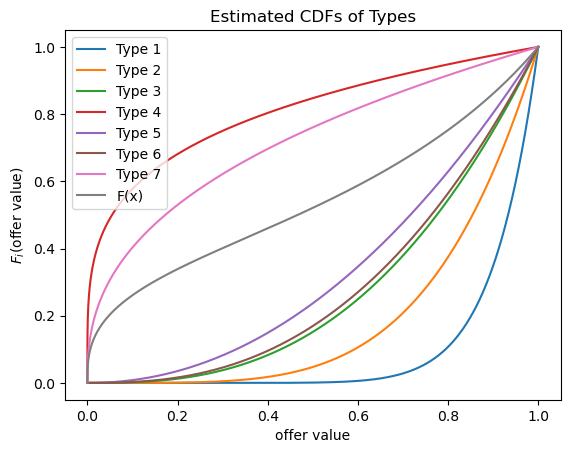

In [30]:
point_grid = [i for i in range(0, 1; length = 10001)]
for select_type in 1:K
    plot(point_grid, [x^estimated_phi[select_type] for x in point_grid], label = string("Type ", select_type))
end

plot(point_grid, [sum(estimated_ρ[i] * x^estimated_phi[i] for i in 1:K) for x in point_grid], label = "F(x)")

title("Estimated CDFs of Types")
xlabel("offer value")
ylabel("\$F_i\$(offer value\$)\$")
legend();

In [31]:
function get_q_vec_stage_3(phi_i, phi_true, ρ_true, v_rel, α, k)
    # given F(x) and a phi_i for F_i(x), computes the success probabilities q_i^t of a tier i department
    
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ_true, phi_true, K) - Fx_vec[t+1], 0.5) 
    end 

    all_integrals_i = get_integral_row(x_vec, phi_i, phi_true, ρ_true, α, k, K)
    q_vec = zeros(k)
    for t in 1:k
        q_vec[t] = q_i(t, all_integrals_i, Fx_vec, α, v_rel, k)
    end
    return q_vec
end

get_q_vec_stage_3 (generic function with 1 method)

In [32]:
endpoint = 10
num_points = 10001
new_point_grid = [i for i in range(0.01, endpoint; length = num_points)]

q_vec_grid = zeros(num_points, 4)
for i in 1:num_points
    q_vec_grid[i, :] = get_q_vec_stage_3(new_point_grid[i], estimated_phi, estimated_ρ, estimated_v_rel, estimated_α, k)
end;

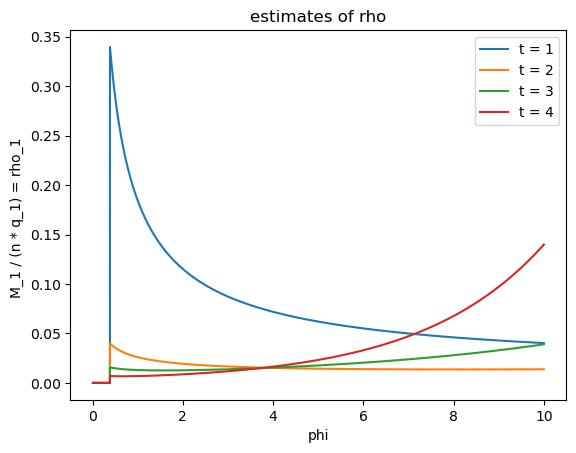

In [33]:
i_tier = 1

for s in 1:4
    plot(new_point_grid, [res.placements[i_tier, s] / (q_vec_grid[i, s] * estimated_n_val) for i in 1:num_points], label = "t = $s")
end
xlabel("phi")
ylabel("M_$(i_tier) / (n * q_$(i_tier)) = rho_$(i_tier) ")
title("estimates of rho")
legend();

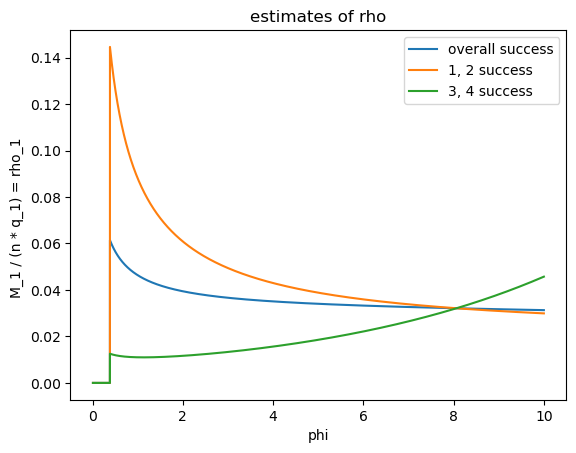

In [34]:
plot(new_point_grid, [sum(res.placements[i_tier, :]) / (sum(q_vec_grid[i, :]) * estimated_n_val) for i in 1:num_points], label = "overall success")
plot(new_point_grid, [((res.placements[i_tier, 1] + res.placements[i_tier, 2]) / ((q_vec_grid[i, 1] + q_vec_grid[i, 2]) * estimated_n_val)) for i in 1:num_points], label = "1, 2 success")
plot(new_point_grid, [((res.placements[i_tier, 3] + res.placements[i_tier, 4]) / ((q_vec_grid[i, 3] + q_vec_grid[i, 4]) * estimated_n_val)) for i in 1:num_points], label = "3, 4 success")

xlabel("phi")
ylabel("M_$(i_tier) / (n * q_$(i_tier)) = rho_$(i_tier) ")
title("estimates of rho")
legend();

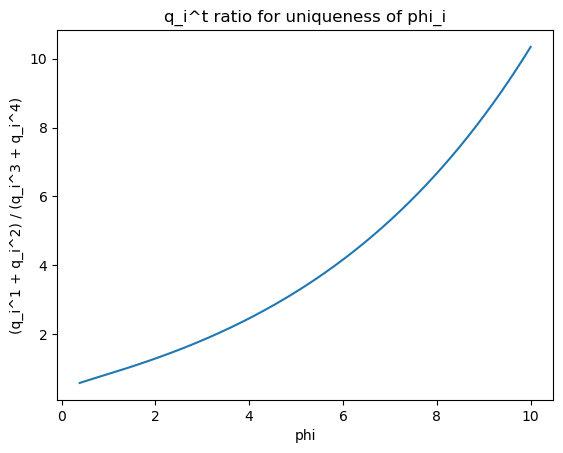

In [35]:
plot(new_point_grid, [((q_vec_grid[i, 1]+q_vec_grid[i, 2]) / (q_vec_grid[i, 3] + q_vec_grid[i, 4])) for i in 1:num_points])
xlabel("phi")
ylabel("(q_i^1 + q_i^2) / (q_i^3 + q_i^4)")
title("q_i^t ratio for uniqueness of phi_i");

In [36]:
function find_q_ratio(phi_i, phi_true, ρ_true, v_rel, α, Fx_vec, x_vec, k, K)
    all_integrals_i = get_integral_row(x_vec, phi_i, phi_true, ρ_true, α, k, K)
    q_vec = zeros(k)
    for t in 1:k
        q_vec[t] = q_i(t, all_integrals_i, Fx_vec, α, v_rel, k)
    end
    return (q_vec[1] + q_vec[2]) / (q_vec[3] + q_vec[4])
end

function estimate_parameters_stage_3(phi_true, ρ_true, v_rel, α, placements, k, K, n_val)   
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.00000001
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ_true, phi_true, K) - Fx_vec[t+1], 0.5)
    end 
    
    phi_vec = zeros(K)
    rho_vec = zeros(K)
    for i in 1:K
        placements_ratio = (placements[i, 1] + placements[i, 2]) / (placements[i, 3] + placements[i, 4])
        phi_i = find_zero(phi -> find_q_ratio(phi, phi_true, ρ_true, v_rel, α, Fx_vec, x_vec, k, K) - placements_ratio, 1.0)
        phi_vec[i] = phi_i
        all_integrals_i = get_integral_row(x_vec, phi_i, phi_true, ρ_true, α, k, K)
        q_sum = q_i(1, all_integrals_i, Fx_vec, α, v_rel, k) + q_i(2, all_integrals_i, Fx_vec, α, v_rel, k)
        rho_vec[i] = (placements[i, 1] + placements[i, 2]) / (n_val * q_sum)
    end
    
    return phi_vec, rho_vec
end

estimate_parameters_stage_3 (generic function with 1 method)

In [37]:
validated_phi, validated_ρ = estimate_parameters_stage_3(estimated_phi, estimated_ρ, estimated_v_rel, estimated_α, res.placements, k, K, estimated_n_val);

In [38]:
estimated_phi

7-element Vector{Float64}:
 9.999999999948804
 4.398285851957321
 2.7202008600268877
 0.23863503235387787
 2.0772261810227945
 2.5618692551777658
 0.39469872767744907

In [39]:
validated_phi

7-element Vector{Float64}:
 8.063418201455198
 4.770419949720624
 2.6666520234635414
 0.38113224851923805
 2.1007845940521657
 2.420531697812708
 0.3850589847625115

In [40]:
estimated_ρ

7-element Vector{Float64}:
 0.03116935383455591
 0.073617364052519
 0.1285316601561245
 0.11338212255262575
 0.09284769968702332
 0.0785343758044307
 0.4819174239127208

In [41]:
validated_ρ

7-element Vector{Float64}:
 0.03212369913214404
 0.07284519185380067
 0.12892957757964282
 0.0973137627863556
 0.09261177021797057
 0.0793111851825338
 0.48624179168407555

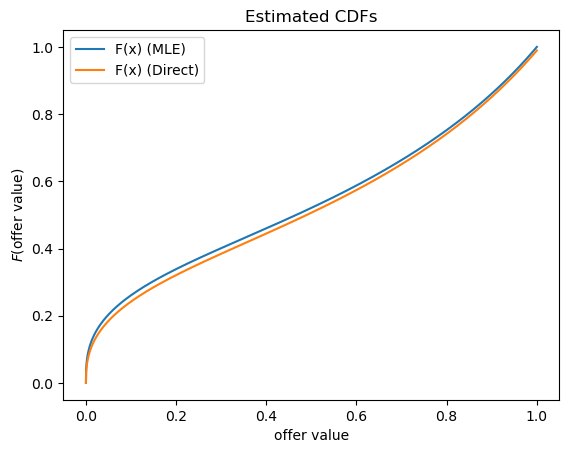

In [42]:
plot(point_grid, [sum(estimated_ρ[i] * x^estimated_phi[i] for i in 1:K) for x in point_grid], label = "F(x) (MLE)")
plot(point_grid, [sum(validated_ρ[i] * x^validated_phi[i] for i in 1:K) for x in point_grid], label = "F(x) (Direct)")
title("Estimated CDFs")
xlabel("offer value")
ylabel("\$F\$(offer value\$)\$")
legend();

In [43]:
function minimize_q_loss(i, phi_i_vec, phi_true, ρ_true, v_rel, α, Fx_vec, x_vec, placements, n_val, k, K)
    phi_i = phi_i_vec[1]
    all_integrals_i = get_integral_row(x_vec, phi_i, phi_true, ρ_true, α, k, K)
    q_vec = zeros(k)
    rho_estimates = zeros(k)
    for t in 1:k
        q_vec[t] = q_i(t, all_integrals_i, Fx_vec, α, v_rel, k)
        rho_estimates[t] = placements[i, t] / (n_val * q_vec[t])
    end

    sum_base = 0.0
    for i in 1:k-1
        for j in i+1:k
            sum_base += ((rho_estimates[i] - rho_estimates[j])^2 / rho_estimates[j])
        end
    end

    left_data = (placements[i, 1]+placements[i, 2]) / (n_val * (q_vec[1]+q_vec[2]))
    right_data = (placements[i, 3]+placements[i, 4]) / (n_val * (q_vec[3]+q_vec[4]))
    sum_base += ((left_data - right_data)^2 / right_data)
    
    return sum_base
end

function estimate_parameters_stage_3a(phi_true, ρ_true, v_rel, α, placements, k, K, n_val)   
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.00000001
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ_true, phi_true, K) - Fx_vec[t+1], (0.0, 1.0))
    end 
    
    phi_vec = zeros(K)
    rho_vec = zeros(K)
    for i in 1:K
        upper_3 = [10.0]
        lower_3 = [0.01]
        search_range_3 = [(lower_3[i], upper_3[i]) for i in eachindex(upper_3)]
        sol_res_3 = bboptimize(phi -> minimize_q_loss(i, phi, phi_true, ρ_true, v_rel, α, Fx_vec, x_vec, placements, n_val, k, K), SearchRange = search_range_3, MaxFuncEvals = 100000, TraceInterval = 5) 
        phi_i = best_candidate(sol_res_3)[1]
        phi_vec[i] = phi_i
        all_integrals_i = get_integral_row(x_vec, phi_i, phi_true, ρ_true, α, k, K)
        q_vec = zeros(k)
        for t in 1:k
            q_vec[t] = q_i(t, all_integrals_i, Fx_vec, α, v_rel, k)
        end
        rho_vec[i] = sum(placements[i, :]) / (n_val * sum(q_vec))
    end
    
    return phi_vec, rho_vec
end

estimate_parameters_stage_3a (generic function with 1 method)

In [44]:
validated_phi_2, validated_ρ_2 = estimate_parameters_stage_3a(estimated_phi, estimated_ρ, estimated_v_rel, estimated_α, res.placements, k, K, estimated_n_val);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 21281 steps and 0.56 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 38206.45
Function evals per second = 23597.84
Improvements/step = Inf
Total function evaluations = 13144


Best candidate found: [7.44225]

Fitness: 0.161685843

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 12388 steps and 0.49 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 25385.25
Function evals per second = 23827.87
Improvements/step = 

In [45]:
estimated_phi

7-element Vector{Float64}:
 9.999999999948804
 4.398285851957321
 2.7202008600268877
 0.23863503235387787
 2.0772261810227945
 2.5618692551777658
 0.39469872767744907

In [46]:
validated_phi

7-element Vector{Float64}:
 8.063418201455198
 4.770419949720624
 2.6666520234635414
 0.38113224851923805
 2.1007845940521657
 2.420531697812708
 0.3850589847625115

In [47]:
validated_phi_2

7-element Vector{Float64}:
 7.4422478487829675
 3.994698466645081
 3.4315240446182877
 0.2700399883831575
 2.136422520259625
 2.533182696399452
 0.37787368761960477

In [48]:
estimated_ρ

7-element Vector{Float64}:
 0.03116935383455591
 0.073617364052519
 0.1285316601561245
 0.11338212255262575
 0.09284769968702332
 0.0785343758044307
 0.4819174239127208

In [49]:
validated_ρ

7-element Vector{Float64}:
 0.03212369913214404
 0.07284519185380067
 0.12892957757964282
 0.0973137627863556
 0.09261177021797057
 0.0793111851825338
 0.48624179168407555

In [50]:
validated_ρ_2

7-element Vector{Float64}:
 0.03242837804336209
 0.0746216897529523
 0.12375518948881438
 0.10888814150899585
 0.09230855873695466
 0.07866387740944485
 0.48917612250370995

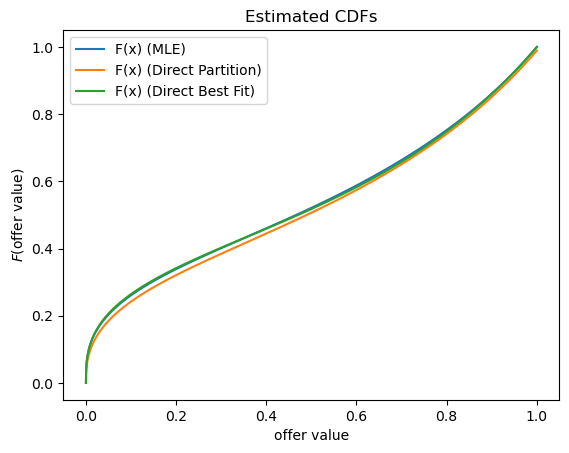

In [51]:
plot(point_grid, [sum(estimated_ρ[i] * x^estimated_phi[i] for i in 1:K) for x in point_grid], label = "F(x) (MLE)")
plot(point_grid, [sum(validated_ρ[i] * x^validated_phi[i] for i in 1:K) for x in point_grid], label = "F(x) (Direct Partition)")
plot(point_grid, [sum(validated_ρ_2[i] * x^validated_phi_2[i] for i in 1:K) for x in point_grid], label = "F(x) (Direct Best Fit)")
title("Estimated CDFs")
xlabel("offer value")
ylabel("\$F\$(offer value\$)\$")
legend();